In [138]:
%matplotlib notebook
import numpy as np
import ipywidgets as widgets
from combine.quick_g import widget_g_plot, quick_g_plot
from matplotlib import pyplot as plt

In [160]:
import numpy as np
from matplotlib import pyplot as plt
import mpl_interactions.ipyplot as iplt
import ipywidgets as widgets

def test_widget_g_plot(g, phi=0, title=None, widget=True, Ri=0, THTi=0):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_aspect("equal")
    if(title is not None): ax.set_title(title)
    fig.tight_layout()
    
    def g_plot(phi):
        ax.clear()
        print(g.shape, phi)
        R, z, _ = np.transpose(g[:,:,phi,:], (2,0,1))
        ax.plot(R,z, c="blue", lw=0.3)
        ax.plot(R[Ri],z[Ri], c="darkblue", lw=2)
        ax.plot(R.T,z.T, c="red", lw=0.3)
        ax.plot(R.T[THTi],z.T[THTi], c="darkred", lw=2)
    
    if widget:
        phi = widgets.IntSlider(min=0, max=g.shape[2]-1, value=phi, step=1)
        widgets.interact(g_plot, phi = phi)
    else:
        g_plot(phi)

In [23]:
def yield_grid_cells(g, r_lahead=1, tht_lahead=1, phi_lahead=0):
    g = g[:,:-1] # remove double tht=0,2pi values
    # implement general looping edges g[r,tht,phi,c]; tht loops, r, phi not
    ors, othts, ophis, _ = g.shape  # original xxx size
    g = np.pad(g, [(0,0), (0,tht_lahead), (0,0), (0,0)], mode='wrap')
    
    # create smaller output array
    h = np.empty((ors-r_lahead, othts, ophis-phi_lahead,
                  1+r_lahead, tht_lahead+1, phi_lahead+1, 3))
    
    # iterate over all parameter coordinates
    for cr in range(ors-r_lahead):
        for ctht in range(othts): #tht loops
            for cphi in range(ophis-phi_lahead):
                h[cr, ctht, cphi] = g[cr:cr+r_lahead+1,
                                      ctht:ctht+tht_lahead+1,
                                      cphi:cphi+phi_lahead+1] 
    return h

In [128]:
def fast_nonconvex(g):
    wv = yield_grid_cells(g, 1, 1, 0)  # window view
    wv =  wv[...,0,:2] # ignore phi component in cell and coord
    # the two directions of cell edges, along r and along tht
    rs, thts, phis = wv.shape[:3]
    # the check works in the way, that the cell has 4 edges and for
    # each edge (going counterclockwise), the other cell corners 
    # need to be on the left side of the edge for the cell to be convex
    # cell edge directions along parametrisation in r and tht
    dir_r, dir_tht  = np.diff(wv, axis=3), np.diff(wv, axis=4)
    # we need to invert half the edge- (2nd in r and 1st in tht) 
    # direction vectors so they point conterclockwise
    # views into dir_r, d_tht for easy access
    dir_r0, dir_r1 = dir_r[...,0,0,:], dir_r[...,0,1,:] 
    dir_tht0, dir_tht1 = dir_tht[...,0,0,:], dir_tht[...,1,0,:]
    dir_r1 *= -1; dir_tht0 *= -1
    # now we need to check if the vectors in order of
    # r[0], tht[1], (-)r[1], (-)tht[0] are always turning left
    # from the last vector (between 0° and 180°).
    # cell convex IFF above true for all four edges
    cross_values = np.empty((rs, thts, phis, 4))
    cross_values[...,0] = np.cross(dir_r0, dir_tht1)
    cross_values[...,1] = np.cross(dir_tht1, dir_r1)
    cross_values[...,2] = np.cross(dir_r1, dir_tht0)
    cross_values[...,3] = np.cross(dir_tht0, dir_r0)
    # we can take the min > 0 to see if all of them are > 0
    is_not_convex = cross_values.min(axis=-1) <= 0
    return is_not_convex

In [122]:
def nonconvex(g):
    wv = yield_grid_cells(g, 1, 1, 0)  # window view
    # the two directions of cell edges, along r and along tht
    rs, thts, phis = wv.shape[:3]
    # skewness on r and tht faces, also named a
    is_convex = np.empty((rs, thts, phis))
    
    # using numpy vector functions is fast, but takes ages to code. will loop
    for r in range(rs):
        for tht in range(thts):
            for phi in range(phis):
                x = wv[r,tht,phi,...,0,:2]
                # from point, to point, *other point indices to check against
                # its just looping through the subarray, feel free to improve
                indices = [[(0,0), (1,0), (1,1), (0,1)],
                           [(1,0), (1,1), (0,1), (0,0)],
                           [(1,1), (0,1), (0,0), (1,0)],
                           [(0,1), (0,0), (1,0), (1,1)]]
                for (of, to, A, B) in indices:
                    di = x[to] - x[of] # direction of line
                    # check if A and B on same side of line. If so, then 
                    # the crossproduct with the direction has the same sign
                    vA = np.sign(np.cross(di, x[A]-x[of]))
                    vB = np.sign(np.cross(di, x[B]-x[of]))
                    if vA == vB:
                        is_convex[r,tht,phi] = vA
                    else:
                        is_convex[r,tht,phi] = 0
    
    return is_convex

In [154]:
gridfile = "/u/phg/grid/tracer/W7X/Grids/new_full_mod_EIM_ERR-test.npz"
g = np.load(gridfile)["data"]

<IPython.core.display.Javascript object>


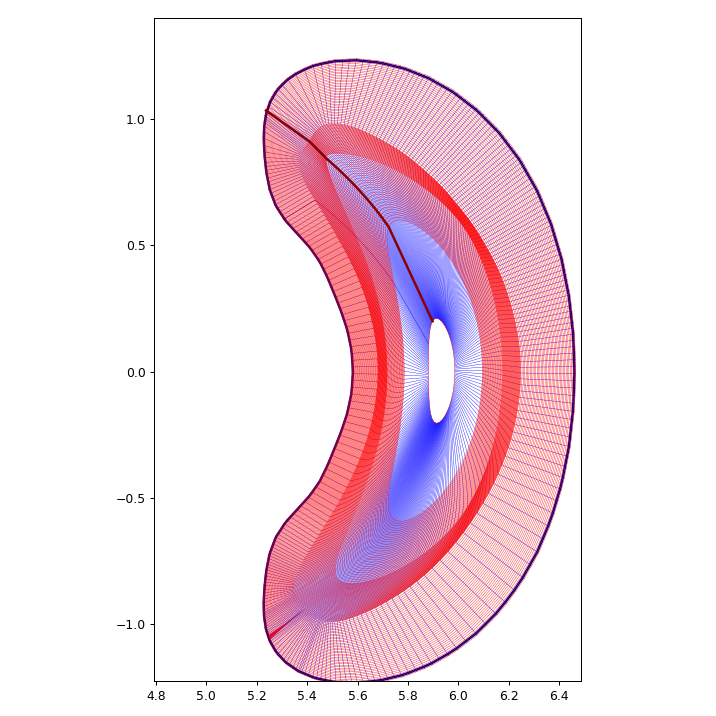

interactive(children=(IntSlider(value=10, description='phi', max=70), Output()), _dom_classes=('widget-interac…

In [162]:
test_widget_g_plot(g, phi=10, Ri=108, THTi=271)

In [151]:
np.any(np.isnan(g))

False

In [152]:
ret = np.nonzero(nonconvex(g) != 1)
nonz1 = np.array([*ret]).T
nonz1.shape, nonz1

((0, 3), array([], shape=(0, 3), dtype=int64))

In [156]:
ret = np.nonzero(fast_nonconvex(g))
nonz2 = np.array([*ret]).T
nonz2.shape, nonz2

((2269, 3),
 array([[ 79,  99,   3],
        [ 80,  99,   1],
        [ 80,  99,   2],
        ...,
        [108, 271,   0],
        [108, 271,   1],
        [108, 271,   2]]))

<IPython.core.display.Javascript object>


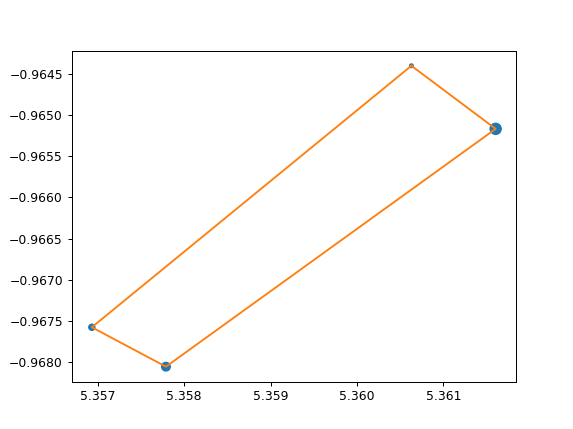

In [163]:
cr, ct, cp = 78, 99, 0
quad = np.array([g[cr,ct,cp][:2], g[cr+1,ct,cp][:2], g[cr+1,ct+1,cp][:2], g[cr,ct+1,cp][:2], g[cr,ct,cp][:2]])
fig, ax = plt.subplots()
ax.scatter(quad[:,0], quad[:,1], s=[9,25,49,81,0])
ax.plot(quad[:,0], quad[:,1], c="C1")

In [ ]:

wv = yield_grid_cells(g, 1, 1, 0)
wv =  wv[...,0,:2] 
rs, thts, phis = wv.shape[:3]
dir_r, dir_tht  = np.diff(wv, axis=3), np.diff(wv, axis=4)
dir_r0, dir_r1 = dir_r[...,0,0,:], dir_r[...,0,1,:] 
dir_tht0, dir_tht1 = dir_tht[...,0,0,:], dir_tht[...,1,0,:]
dir_r1 *= -1; dir_tht0 *= -1
cross_values = np.empty((rs, thts, phis, 4))
cross_values[...,0] = np.cross(dir_r0, dir_tht1)
cross_values[...,1] = np.cross(dir_tht1, dir_r1)
cross_values[...,2] = np.cross(dir_r1, dir_tht0)
cross_values[...,3] = np.cross(dir_tht0, dir_r0)
return cross_values.min(axis=-1) <= 0